# Tutorial of `fitburst` -- III: Generating Models

The goal of `fitburst` is to generate noiseless, best-fit representations of dynamic spectra (DSs). This process assumes an underlying model of the pulse shape while accounting for "global" effects like dispersion and scatter-broadening. To this end, the `fitburst` codebase offers the `SpectrumModeler` object to configure, update, and generate DS models assuming that the pulse has an intrinsically Gaussian shape. 

This tutorial demonstrates the use of the `SpectrumModeler` object.

## Step 1: load and/or generate data needed to define the DS. 

Let's say we want to generate a model of the example data set provided in this repository. This data set contains a bunch of information needed to specify a model (e.g., frequency/time resolution, etc.), and so we may as well load those data in here:

In [1]:
# import the necessary utilities.
from fitburst.backend.generic import DataReader
from fitburst.analysis.model import SpectrumModeler
import matplotlib.pyplot as plt
import numpy as np

# initialize the DataReader object.
input_file = "./data_fitburst_CHIMEFRB_StokesI_FRB20220502B.npz"
data = DataReader(input_file)
data.load_data()

Before moving on, it is important to note and emphasize: _the generation of DS models does not rely on the `DataReader` object._ We are merely making use of available data to generate a model, but we can instead simulate metadata and use the `SpectrumModeler` object without ever needing to rely on the `DataReader`. This independence allows for broader applications of `SpectrumModeler`, as will be shown in one or several companion notebooks that illustrate examples of its use.

## Step 2: instantiate and overload the `SpectrumModeler` object

The `SpectrumModeler` needs at least three pieces of information to compute a model, but only requires two for instantiation of the object: the arrays that specify the values of frequency channels and time samples at which to evaluate the DS.

In [3]:
# instantiate the DS-model object.
model_obj = SpectrumModeler(data.freqs, data.times)

## Step 3: define the model parameters

In order to fully determine a model, the `SpectrumModeler` object must be given a set values for the model parameters. This operation is currently done by (1) creating a Python dictionary of parameters, and then (2) supplying this dictionary to the instantiated `SpectrumModeler` object. For the first step, let's start with understanding what parameters are understood by the `SpectrumModeler`:

In [7]:
# print list of parameters understood by the SpectrumModeler
print(model_obj.parameters)

['amplitude', 'arrival_time', 'burst_width', 'dm', 'dm_index', 'scattering_timescale', 'scattering_index', 'spectral_index', 'spectral_running']


These parameters match those that are described in the Fonseca et al. (2024) paper that describes `fitburst`, and are summarized on the [documentation page describing the `SpectrumModeler`](https://chimefrb.github.io/fitburst/usage/creating_models/#parameters-of-the-model-object). By definition, the `fitburst`-generic data file contains a full list of model parameters correspond to an initial guess or previous `fitburst` fit that generated the file: 

In [8]:
# print parameters contained in the `DataReader` object.
import pprint

params = data.burst_parameters
pprint.pprint(params)

{'amplitude': [-0.4812764314320905],
 'arrival_time': [1060314.803224573],
 'burst_width': [0.00027258462551453457],
 'dm': [623.684276828633],
 'dm_index': [-2.0],
 'ref_freq': [400.1953125],
 'scattering_index': [-4.0],
 'scattering_timescale': [0.0],
 'spectral_index': [2.8705490561459213],
 'spectral_running': [-15.86167822219646]}


Three things are worth noting about the `DataReader.burst_parameters` attribute:
* the `amplitude` parameter represents the log base 10 of the actual amplitude of the signal, which is why the above value is negative;
* all parameters are specified as Python lists of length equal to the number of burst "components" (i.e., distinct pulses) in the DS;
* the `ref_freq` parameter represents the reference frequency for the "running power law" spectral energy distribution and is assumed to be a constant (**not fittable**)  parameter; it can be set to whatever value you'd like, but we recommend setting it to be a value within or at an edge of the data bandwidth.

## Step 4: overloading parameters into the `SpectrumModeler`

Wit the above state, we can now overload the `SpectrumModeler` parameters with meaningful values (after making a few tweaks that will be explained in Step 6):

In [38]:
# tweak DM and arrival-time value before moving on.
params["dm"] = [0.]
params["arrival_time"] = [np.mean(data.times)]

# overload parameter values into the SpectrumModel instance.
model_obj.update_parameters(params)

## Step 5: computing the model DS.

The model DS can now finally be computed by using the `compute_model()` method within the `SpectrumModeler` object:

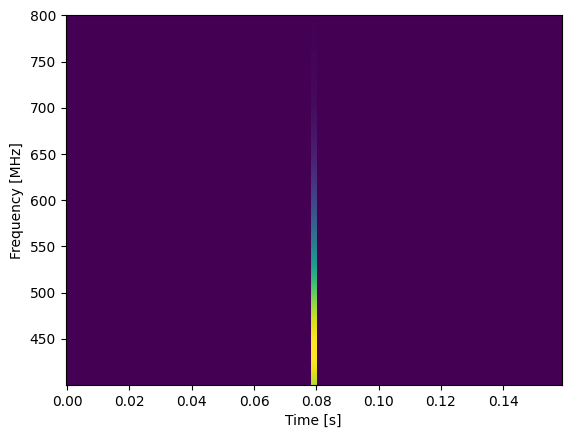

In [39]:
# finally, compute a model.
model = model_obj.compute_model()

# now plot.
plt.pcolormesh(data.times, data.freqs, model)
plt.xlabel("Time [s]")
plt.ylabel("Frequency [MHz]")
plt.show()

## Step 6: updating model parameters.

As mentioned in Step 4, we tweaked a couple of parameter values before creating the above model. These tweaks were done for two reasons:
1. the `DataReader.times` array contains values of _relative_ time values in units of seconds, with the first value being equal to 0 s. However, the `DataReader.burst_parameters` has an _absolute" value of `arrival_time` (also in units of seconds) that is specific to CHIME/FRB time-tagging. We could have adjusted the `DataReader.times` array by adding the absolute value of the first time bin that is stored in `DataReader.times_bin0` attribute, but we instead chose to keep a relative time above. (This choice is arbitrary and mainly done to make the x-axis of the above plot easier to read.) We therefore instead adjusted the `arrival_time` value to be in the middle of the `DataReader.times` array;
2. the `DataReader.burst_parameters` attribute contains an absolute value of `dm`, whereas the data stored in `DataReader.data_full` data contain a de-dispersed spectrum as indicated by the `DataReader.is_dedipsersed` attribute:

In [34]:
# check if data are dedispersed.
print(f"The recorded spectrum is already dedispersed: {data.is_dedispersed}")

The recorded spectrum is already dedispersed: True


We therefore wanted to create a model of a dedispersed pulse, i.e., a pulse with DM = 0 pc/cc. 

However, let's say we were instead interested in computing a model for a pulse with the same parameters as above but with slight dispersion, say DM = 1.0 pc/cc. We can update the above instance of the `SpectrumModeler` for its values of DM:

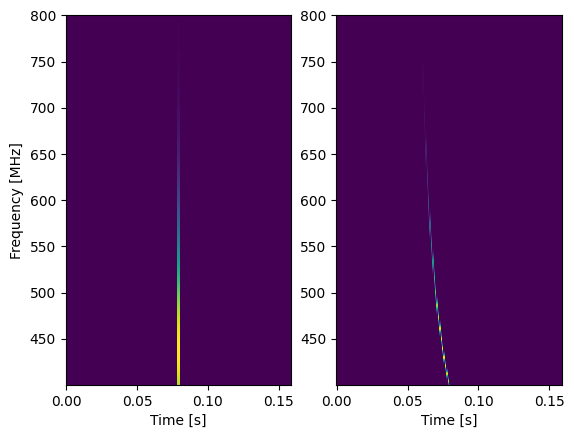

In [40]:
# change the DM values in the instantiated SpectrumModeler object.
model_obj.update_parameters({"dm": [1.0]})
model2 = model_obj.compute_model()

# now plot.
plt.subplot(1,2,1)
plt.pcolormesh(data.times, data.freqs, model)
plt.xlabel("Time [s]")
plt.ylabel("Frequency [MHz]")
plt.subplot(1,2,2)
plt.pcolormesh(data.times, data.freqs, model2)
plt.xlabel("Time [s]")
plt.show()